# Sarcasm Detection in News Headlines: Full Pipeline Demo

**Author:** Deogyong Kim (2021134015)

This notebook demonstrates a complete pipeline for detecting sarcasm in news headlines, comparing five different approaches:
1. Naive Baseline (rule-based)
2. Embedding + Centroid
3. Embedding + Logistic Regression
4. LLM Zero-shot
5. LLM Few-shot

## 0. Environment Setup

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn tqdm torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 transformers==4.51.3 sentence-transformers accelerate autoawq openai huggingface_hub
print("All packages installed successfully!")

All packages installed successfully!


In [2]:
# Verify installations
import sys
import torch
print(f"\nPython version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Download Qwen model if not exists
import os
from pathlib import Path

MODEL_DIR = Path.home() / "model"
MODEL_NAME = "Qwen/Qwen2.5-32B-Instruct-AWQ"
LOCAL_MODEL_PATH = MODEL_DIR / "Qwen2.5-32B-Instruct-AWQ"

if not LOCAL_MODEL_PATH.exists():
    print(f"\n{'='*70}")
    print("Downloading Qwen2.5-32B-Instruct-AWQ model...")
    print(f"This will take a while (~20 GB download)")
    print(f"{'='*70}\n")
    
    from huggingface_hub import snapshot_download
    
    snapshot_download(
        repo_id=MODEL_NAME,
        local_dir=str(LOCAL_MODEL_PATH),
        local_dir_use_symlinks=False,
        resume_download=True
    )
    print(f"\n Model downloaded to {LOCAL_MODEL_PATH}")
else:
    print(f"\n Model already exists at {LOCAL_MODEL_PATH}")

print("\n Ready to proceed!")


Python version: 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU: NVIDIA GeForce RTX 3090

 Model already exists at /root/model/Qwen2.5-32B-Instruct-AWQ

 Ready to proceed!


## 1. Setup and Imports

In [3]:
import pandas as pd
import numpy as np
import json
import time
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import defaultdict

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression

# Models
from sentence_transformers import SentenceTransformer
from openai import OpenAI
from tqdm.notebook import tqdm

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All imports successful
PyTorch version: 2.6.0+cu124
CUDA available: True


## 2. Configuration

In [4]:
# Configuration
DATA_FILE = "../data/Sarcasm_Headlines_Dataset_v2.json"
RESULTS_DIR = "../results"

# LLM API
LLM_API_BASE = "http://localhost:8000/v1"
LLM_API_KEY = "EMPTY"

# Experiment settings
RANDOM_SEED = 42
TEST_SIZE = 0.2
EMBEDDING_MODEL = "all-mpnet-base-v2"

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print(f"Configuration loaded")
print(f"  Random seed: {RANDOM_SEED}")
print(f"  Test size: {TEST_SIZE}")
print(f"  Embedding model: {EMBEDDING_MODEL}")

Configuration loaded
  Random seed: 42
  Test size: 0.2
  Embedding model: all-mpnet-base-v2


## 3. Load and Explore Data

In [5]:
# 3. Load and Explore Data

import json
import shutil

# Check if dataset exists, if not download from Kaggle
if not os.path.exists(DATA_FILE):
    print(f"Dataset not found at {DATA_FILE}")
    print("Downloading from Kaggle...")
    
    !pip install -q kagglehub
    import kagglehub
    
    # Download dataset
    path = kagglehub.dataset_download("rmisra/news-headlines-dataset-for-sarcasm-detection")
    print(f"Downloaded to: {path}")
    
    # Find and move the JSON file
    os.makedirs(os.path.dirname(DATA_FILE), exist_ok=True)
    downloaded_file = os.path.join(path, "Sarcasm_Headlines_Dataset_v2.json")
    shutil.copy(downloaded_file, DATA_FILE)
    print(f"✓ Dataset copied to {DATA_FILE}")
else:
    print(f"✓ Dataset found at {DATA_FILE}")

# Load dataset
df = pd.read_json(DATA_FILE, lines=True)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nClass distribution:")
print(df['is_sarcastic'].value_counts())
print(f"\nClass percentages:")
print(df['is_sarcastic'].value_counts(normalize=True) * 100)

✓ Dataset found at ../data/Sarcasm_Headlines_Dataset_v2.json
Dataset shape: (28619, 3)

Columns: ['is_sarcastic', 'headline', 'article_link']

Class distribution:
is_sarcastic
0    14985
1    13634
Name: count, dtype: int64

Class percentages:
is_sarcastic
0    52.36032
1    47.63968
Name: proportion, dtype: float64


In [6]:
# Display sample headlines
print("Sample REAL headlines:")
for headline in df[df['is_sarcastic'] == 0]['headline'].head(5):
    print(f"  • {headline}")

print("\nSample SATIRE headlines:")
for headline in df[df['is_sarcastic'] == 1]['headline'].head(5):
    print(f"  • {headline}")

Sample REAL headlines:
  • dem rep. totally nails why congress is falling short on gender, racial equality
  • eat your veggies: 9 deliciously different recipes
  • my white inheritance
  • 5 ways to file your taxes with less stress
  • lots of parents know this scenario

Sample SATIRE headlines:
  • thirtysomething scientists unveil doomsday clock of hair loss
  • inclement weather prevents liar from getting to work
  • mother comes pretty close to using word 'streaming' correctly
  • richard branson's global-warming donation nearly as much as cost of failed balloon trips
  • shadow government getting too large to meet in marriott conference room b


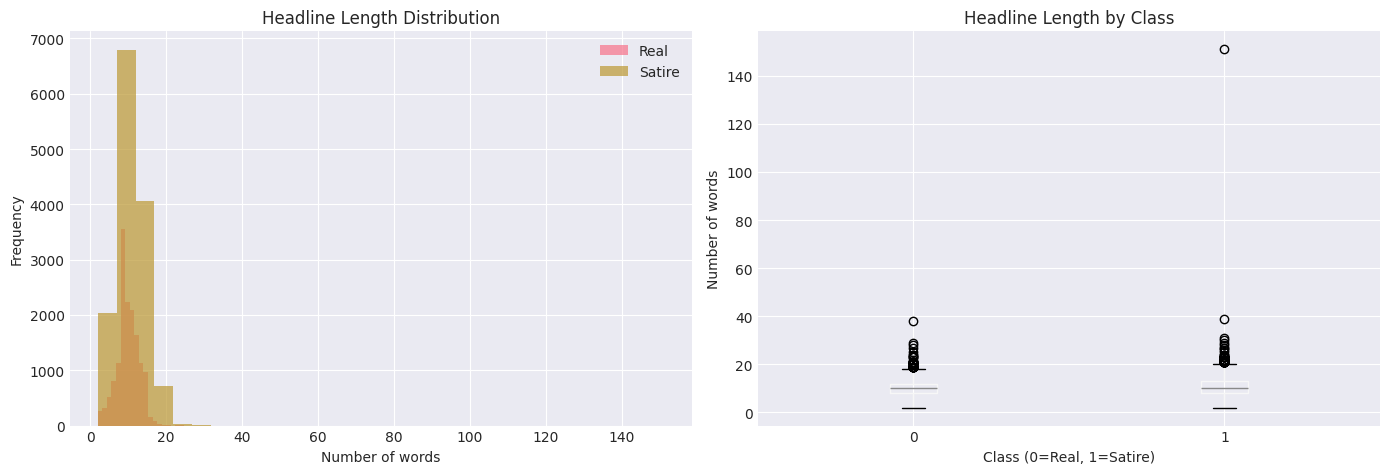

Average headline length:
  Real: 9.82 words
  Satire: 10.31 words


In [7]:
# Headline length distribution
df['headline_length'] = df['headline'].str.split().str.len()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Length distribution by class
df[df['is_sarcastic'] == 0]['headline_length'].hist(bins=30, alpha=0.7, label='Real', ax=ax[0])
df[df['is_sarcastic'] == 1]['headline_length'].hist(bins=30, alpha=0.7, label='Satire', ax=ax[0])
ax[0].set_xlabel('Number of words')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Headline Length Distribution')
ax[0].legend()

# Box plot
df.boxplot(column='headline_length', by='is_sarcastic', ax=ax[1])
ax[1].set_xlabel('Class (0=Real, 1=Satire)')
ax[1].set_ylabel('Number of words')
ax[1].set_title('Headline Length by Class')
plt.suptitle('')

plt.tight_layout()
plt.show()

print(f"Average headline length:")
print(f"  Real: {df[df['is_sarcastic'] == 0]['headline_length'].mean():.2f} words")
print(f"  Satire: {df[df['is_sarcastic'] == 1]['headline_length'].mean():.2f} words")

## 4. Train/Test Split

In [8]:
# Split data
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_SEED)

print(f"Training set: {len(train_df):,} samples")
print(f"Test set: {len(test_df):,} samples")
print(f"\nTrain class distribution:")
print(train_df['is_sarcastic'].value_counts())
print(f"\nTest class distribution:")
print(test_df['is_sarcastic'].value_counts())

Training set: 22,895 samples
Test set: 5,724 samples

Train class distribution:
is_sarcastic
0    11990
1    10905
Name: count, dtype: int64

Test class distribution:
is_sarcastic
0    2995
1    2729
Name: count, dtype: int64


## 5. Method 1: Naive Baseline

A simple rule-based approach using keyword scoring:
- Intensifiers (+1.5): "absolutely", "totally", "perfect", etc.
- Satirical triggers (+2.0): "area man", "nation", "study finds", etc.
- Punctuation (+0.5): !, ?, or quotes

Headlines scoring ≥ 1.5 are classified as satire.

In [9]:
def get_sarcasm_score(headline):
    """Calculate sarcasm score based on keyword rules."""
    text = headline.lower()
    score = 0
    
    intensifiers = [
        'absolutely', 'totally', 'clearly', 'literally', 'completely', 
        'miracle', 'amazing', 'perfect', 'best', 'worst', 'incredible',
        'shocking', 'breaking', 'finally'
    ]
    for word in intensifiers:
        if word in text.split():
            score += 1.5
    
    sarcasm_triggers = [
        'area man', 'area woman', 'local man', 'local woman', 
        'nation', 'study finds', 'report:', 'god', 'scientists'
    ]
    for trigger in sarcasm_triggers:
        if trigger in text:
            score += 2.0
    
    if '!' in text or '?' in text:
        score += 0.5
    if '"' in text:
        score += 0.5
        
    return score

def predict_baseline(headlines, threshold=1.5):
    """Predict using naive baseline."""
    predictions = []
    for headline in headlines:
        score = get_sarcasm_score(headline)
        predictions.append(1 if score >= threshold else 0)
    return predictions

# Test the scoring function
test_headlines = [
    "area man passionate defender of what he imagines constitution to be",
    "trump announces new immigration policy"
]
for headline in test_headlines:
    score = get_sarcasm_score(headline)
    print(f"Score: {score:.1f} | {headline}")

Score: 2.0 | area man passionate defender of what he imagines constitution to be
Score: 0.0 | trump announces new immigration policy


In [10]:
# Run naive baseline
print("Running Naive Baseline...")
y_pred_naive = predict_baseline(test_df['headline'].values, threshold=1.5)
y_true = test_df['is_sarcastic'].values

# Calculate metrics
naive_results = {
    'accuracy': accuracy_score(y_true, y_pred_naive),
    'f1': f1_score(y_true, y_pred_naive),
    'precision': precision_score(y_true, y_pred_naive),
    'recall': recall_score(y_true, y_pred_naive)
}

print(f"\nNaive Baseline Results:")
print(f"  Accuracy:  {naive_results['accuracy']:.4f} ({naive_results['accuracy']*100:.2f}%)")
print(f"  F1 Score:  {naive_results['f1']:.4f}")
print(f"  Precision: {naive_results['precision']:.4f}")
print(f"  Recall:    {naive_results['recall']:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_true, y_pred_naive, target_names=['Real', 'Satire']))

Running Naive Baseline...

Naive Baseline Results:
  Accuracy:  0.5646 (56.46%)
  F1 Score:  0.2421
  Precision: 0.7120
  Recall:    0.1458

Classification Report:
              precision    recall  f1-score   support

        Real       0.55      0.95      0.69      2995
      Satire       0.71      0.15      0.24      2729

    accuracy                           0.56      5724
   macro avg       0.63      0.55      0.47      5724
weighted avg       0.63      0.56      0.48      5724



## 6. Method 2: Embedding + Centroid

Uses Sentence-BERT to encode headlines into 768-dimensional vectors.
Classifies based on cosine similarity to class centroids (mean vectors).
No training required.

In [11]:
# Load Sentence-BERT model
print(f"Loading Sentence-BERT model: {EMBEDDING_MODEL}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

sbert_model = SentenceTransformer(EMBEDDING_MODEL, device=device)
print("Model loaded")

Loading Sentence-BERT model: all-mpnet-base-v2
Using device: cuda
Model loaded


In [12]:
# Encode training set and compute centroids
print("Encoding training set...")
X_train = sbert_model.encode(train_df['headline'].tolist(), show_progress_bar=True)
y_train = train_df['is_sarcastic'].values

print(f"Training embeddings shape: {X_train.shape}")

# Compute class centroids
centroid_satire = np.mean(X_train[y_train == 1], axis=0).reshape(1, -1)
centroid_real = np.mean(X_train[y_train == 0], axis=0).reshape(1, -1)

print(f"Satire centroid shape: {centroid_satire.shape}")
print(f"Real centroid shape: {centroid_real.shape}")

Encoding training set...


Batches:   0%|          | 0/716 [00:00<?, ?it/s]

Training embeddings shape: (22895, 768)
Satire centroid shape: (1, 768)
Real centroid shape: (1, 768)


In [13]:
# Encode test set
print("Encoding test set...")
X_test = sbert_model.encode(test_df['headline'].tolist(), show_progress_bar=True)
print(f"Test embeddings shape: {X_test.shape}")

Encoding test set...


Batches:   0%|          | 0/179 [00:00<?, ?it/s]

Test embeddings shape: (5724, 768)


In [14]:
# Classify using centroid distance
print("Classifying test samples...")
y_pred_centroid = []
for vec in X_test:
    vec = vec.reshape(1, -1)
    sim_satire = cosine_similarity(vec, centroid_satire)[0][0]
    sim_real = cosine_similarity(vec, centroid_real)[0][0]
    y_pred_centroid.append(1 if sim_satire > sim_real else 0)

# Calculate metrics
centroid_results = {
    'accuracy': accuracy_score(y_true, y_pred_centroid),
    'f1': f1_score(y_true, y_pred_centroid),
    'precision': precision_score(y_true, y_pred_centroid),
    'recall': recall_score(y_true, y_pred_centroid)
}

print(f"\nEmbedding + Centroid Results:")
print(f"  Accuracy:  {centroid_results['accuracy']:.4f} ({centroid_results['accuracy']*100:.2f}%)")
print(f"  F1 Score:  {centroid_results['f1']:.4f}")
print(f"  Precision: {centroid_results['precision']:.4f}")
print(f"  Recall:    {centroid_results['recall']:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_true, y_pred_centroid, target_names=['Real', 'Satire']))

Classifying test samples...

Embedding + Centroid Results:
  Accuracy:  0.7472 (74.72%)
  F1 Score:  0.7331
  Precision: 0.7381
  Recall:    0.7281

Classification Report:
              precision    recall  f1-score   support

        Real       0.76      0.76      0.76      2995
      Satire       0.74      0.73      0.73      2729

    accuracy                           0.75      5724
   macro avg       0.75      0.75      0.75      5724
weighted avg       0.75      0.75      0.75      5724



## 7. Method 3: Embedding + Logistic Regression

Uses the same Sentence-BERT embeddings but trains a Logistic Regression classifier
to learn a task-specific decision boundary in the embedding space.

In [15]:
# Train Logistic Regression
print("Training Logistic Regression classifier...")
lr_clf = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, solver='lbfgs', verbose=0)
lr_clf.fit(X_train, y_train)
print("Training complete")

Training Logistic Regression classifier...
Training complete


In [16]:
# Predict on test set
print("Predicting on test set...")
y_pred_lr = lr_clf.predict(X_test)

# Calculate metrics
lr_results = {
    'accuracy': accuracy_score(y_true, y_pred_lr),
    'f1': f1_score(y_true, y_pred_lr),
    'precision': precision_score(y_true, y_pred_lr),
    'recall': recall_score(y_true, y_pred_lr)
}

print(f"\nEmbedding + LR Results:")
print(f"  Accuracy:  {lr_results['accuracy']:.4f} ({lr_results['accuracy']*100:.2f}%)")
print(f"  F1 Score:  {lr_results['f1']:.4f}")
print(f"  Precision: {lr_results['precision']:.4f}")
print(f"  Recall:    {lr_results['recall']:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_true, y_pred_lr, target_names=['Real', 'Satire']))

Predicting on test set...

Embedding + LR Results:
  Accuracy:  0.8471 (84.71%)
  F1 Score:  0.8382
  Precision: 0.8462
  Recall:    0.8303

Classification Report:
              precision    recall  f1-score   support

        Real       0.85      0.86      0.86      2995
      Satire       0.85      0.83      0.84      2729

    accuracy                           0.85      5724
   macro avg       0.85      0.85      0.85      5724
weighted avg       0.85      0.85      0.85      5724



## Method 4 & 5 Setup: LLM with vLLM or Transformers

In [17]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from pathlib import Path

# Load LLM model
LOCAL_MODEL_PATH = Path.home() / "model" / "Qwen2.5-32B-Instruct-AWQ"

print(f"Loading Qwen2.5-32B-Instruct from {LOCAL_MODEL_PATH}...")
tokenizer = AutoTokenizer.from_pretrained(str(LOCAL_MODEL_PATH))
llm_model = AutoModelForCausalLM.from_pretrained(
    str(LOCAL_MODEL_PATH),
    device_map="auto",
    torch_dtype=torch.float16
)
print(f"✓ Model loaded (GPU memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB)")
print("="*70)

Loading Qwen2.5-32B-Instruct from /root/model/Qwen2.5-32B-Instruct-AWQ...


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
/usr/local/lib/python3.10/dist-packages/awq/__init__.py:21: DeprecationWarning: 
I have left this message as the final dev message to help you transition.

Important Notice:
- AutoAWQ is officially deprecated and will no longer be maintained.
- The last tested configuration used Torch 2.6.0 and Transformers 4.51.3.
- If future versions of Transformers break AutoAWQ compatibility, please report the issue to the Transformers project.

Alternative:
- AutoAWQ has been adopted by the vLLM Project: https://github.com/vllm-project/llm-compressor

For further inquiries, feel free to reach out:
- X: https://x.com/casper_hansen_
- LinkedIn: https://www.linkedin.com/in/casper-hansen-804005170/

  warnings.warn(_FINAL_DEV_MESSAGE, category=DeprecationWarning, stacklevel=1)


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

✓ Model loaded (GPU memory: 18.48 GB)


## 8. Method 4: LLM Zero-shot

Zero-shot classification using Qwen2.5-32B-Instruct.

In [18]:
def query_zeroshot(headline):
    """Query LLM with zero-shot prompt."""
    system_prompt = """You are an expert linguist identifying satire. 
Classify the given news headline into 'Satire' (The Onion) or 'Real' (HuffPost).
DEFINITION OF SATIRE (The Onion):
1. Absurd situations that violate physical laws or logic.
2. Mundane, trivial everyday behaviors presented as 'breaking news'.
3. Specific satirical phrases: 'Area Man', 'Nation', 'Study finds'.
DEFINITION OF REAL NEWS:
1. Factual reporting about specific politicians, celebrities, or companies.
2. Opinions or commentaries on actual political/social events.
3. Even if the event sounds strange, if it involves real entities, it is likely Real."""
    
    user_prompt = f'Headline: "{headline}"\n\nClassify as \'Satire\' or \'Real\'.'
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
    
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer([text], return_tensors="pt").to(llm_model.device)
    
    outputs = llm_model.generate(
        **inputs,
        max_new_tokens=10,
        do_sample=False  
    )
    
    result = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return result.strip()

# Test the function
test_output = query_zeroshot("area man passionate defender of what he imagines constitution to be")
print(f"Test output: {test_output}")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Test output: Classification: Satire

Explanation: The headline uses


In [19]:
# Run LLM zero-shot on test set
print(f"Running LLM Zero-shot on {len(test_df)} samples...")
print("This may take a while depending on GPU speed.\n")

y_pred_llm_zero = []
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    output = query_zeroshot(row['headline'])
    y_pred_llm_zero.append(1 if "satire" in output.lower() else 0)

# Calculate metrics
llm_zero_results = {
    'accuracy': accuracy_score(y_true, y_pred_llm_zero),
    'f1': f1_score(y_true, y_pred_llm_zero),
    'precision': precision_score(y_true, y_pred_llm_zero),
    'recall': recall_score(y_true, y_pred_llm_zero)
}

print(f"\nLLM Zero-shot Results:")
print(f"  Accuracy:  {llm_zero_results['accuracy']:.4f} ({llm_zero_results['accuracy']*100:.2f}%)")
print(f"  F1 Score:  {llm_zero_results['f1']:.4f}")
print(f"  Precision: {llm_zero_results['precision']:.4f}")
print(f"  Recall:    {llm_zero_results['recall']:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_true, y_pred_llm_zero, target_names=['Real', 'Satire']))

Running LLM Zero-shot on 5724 samples...
This may take a while depending on GPU speed.



  0%|          | 0/5724 [00:00<?, ?it/s]


LLM Zero-shot Results:
  Accuracy:  0.8187 (81.87%)
  F1 Score:  0.7995
  Precision: 0.8455
  Recall:    0.7582

Classification Report:
              precision    recall  f1-score   support

        Real       0.80      0.87      0.83      2995
      Satire       0.85      0.76      0.80      2729

    accuracy                           0.82      5724
   macro avg       0.82      0.82      0.82      5724
weighted avg       0.82      0.82      0.82      5724



## 9. Method 5: LLM Few-shot

Same LLM but with 8 example headlines (4 satire + 4 real) in the prompt.
Shows the model what kinds of headlines belong to each class.

In [20]:
def query_fewshot(headline):
    """Query LLM with few-shot prompt."""
    system_prompt = """You distinguish The Onion satire from real news.
SATIRICAL (The Onion):
- "Area man/woman" + mundane behavior as news
- "Nation" as a character doing absurd things
- "Study finds" + obvious common sense
- "Report:" + self-evident statements
- "God" making mundane announcements
- Ordinary events as breaking news
- Exaggerated absolute language
- Generic people in mundane situations
- Real politicians/Celebrities doing oddly mundane or out-of-character things
- Companies announcing products that already exist or are useless
REAL NEWS (even if unusual):
- Named politicians, celebrities, companies
- Actual products and marketing campaigns
- Real sports events and commentary
- Legal cases with specific parties
- Entertainment industry announcements
- Opinion pieces on current events
- Weird pop-culture news or bizarre viral trends
CRITICAL: Many real news articles are weird, provocative, or satirical in TONE but describe REAL events/people/products. If it mentions specific names or real entities, it is usually REAL, UNLESS the action they are doing is functionally useless or weirdly mundane."""
    
    user_prompt = f"""EXAMPLES:

SATIRICAL:
"area man passionate defender of what he imagines constitution to be"
"nation celebrates full week without mass shooting"
"ford develops new suv that runs purely on gasoline"
(Reason: Real company (Ford) but announcing a mundane product feature as innovation.)
"eric holder loads ipod with ap phone conversations for morning commute"
(Reason: Real politician (Eric Holder) doing a bizarrely mundane/specific action.)

REAL (even though they sound satirical):
"the gop's stockholm syndrome"
(Reason: Political opinion/metaphor.)
"riot grill for meat-loving feminists"
(Reason: Real restaurant/marketing.)
"jon snow has been battling white walkers while wearing an ikea rug"
(Reason: Real entertainment news about a TV show costume.)
"10-pound doughnut at hotel"
(Reason: Real product announcement.)

Classify: "{headline}"

Answer: Satire or Real"""
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
    
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer([text], return_tensors="pt").to(llm_model.device)
    
    outputs = llm_model.generate(
        **inputs,
        max_new_tokens=10,
        do_sample=False  
    )
    
    result = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return result.strip()

# Test the function
test_output = query_fewshot("area man passionate defender of what he imagines constitution to be")
print(f"Test output: {test_output}")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Test output: Classification: Satire

Explanation: The phrase "


In [21]:
# Run LLM few-shot on test set
print(f"Running LLM Few-shot on {len(test_df)} samples...")
print("This may take a while depending on GPU speed.\n")

y_pred_llm_few = []
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    output = query_fewshot(row['headline'])
    y_pred_llm_few.append(1 if "satire" in output.lower() else 0)

# Calculate metrics
llm_few_results = {
    'accuracy': accuracy_score(y_true, y_pred_llm_few),
    'f1': f1_score(y_true, y_pred_llm_few),
    'precision': precision_score(y_true, y_pred_llm_few),
    'recall': recall_score(y_true, y_pred_llm_few)
}

print(f"\nLLM Few-shot Results:")
print(f"  Accuracy:  {llm_few_results['accuracy']:.4f} ({llm_few_results['accuracy']*100:.2f}%)")
print(f"  F1 Score:  {llm_few_results['f1']:.4f}")
print(f"  Precision: {llm_few_results['precision']:.4f}")
print(f"  Recall:    {llm_few_results['recall']:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_true, y_pred_llm_few, target_names=['Real', 'Satire']))

Running LLM Few-shot on 5724 samples...
This may take a while depending on GPU speed.



  0%|          | 0/5724 [00:00<?, ?it/s]


LLM Few-shot Results:
  Accuracy:  0.8295 (82.95%)
  F1 Score:  0.8402
  Precision: 0.7595
  Recall:    0.9399

Classification Report:
              precision    recall  f1-score   support

        Real       0.93      0.73      0.82      2995
      Satire       0.76      0.94      0.84      2729

    accuracy                           0.83      5724
   macro avg       0.84      0.83      0.83      5724
weighted avg       0.85      0.83      0.83      5724



## 10. Performance Comparison

In [22]:
# Compile all results
all_results = {
    'Naive Baseline': naive_results,
    'Embedding + Centroid': centroid_results,
    'Embedding + LR': lr_results,
    'LLM Zero-shot': llm_zero_results,
    'LLM Few-shot': llm_few_results
}

# Create comparison dataframe
results_df = pd.DataFrame(all_results).T
results_df = results_df[['accuracy', 'f1', 'precision', 'recall']]

print("\n" + "="*70)
print("PERFORMANCE COMPARISON (Table 1 from report)")
print("="*70)
print(results_df.to_string())
print("="*70)


PERFORMANCE COMPARISON (Table 1 from report)
                      accuracy        f1  precision    recall
Naive Baseline        0.564640  0.242092   0.711986  0.145841
Embedding + Centroid  0.747205  0.733075   0.738113  0.728106
Embedding + LR        0.847135  0.838173   0.846154  0.830341
LLM Zero-shot         0.818658  0.799459   0.845525  0.758153
LLM Few-shot          0.829490  0.840157   0.759550  0.939905


## 11. Qualitative Analysis

Examining cases where methods agree or disagree to understand their strengths and weaknesses.

In [25]:
# Create analysis dataframe
analysis_df = test_df.copy()
analysis_df['true_label'] = y_true
analysis_df['naive'] = y_pred_naive
analysis_df['embedding_lr'] = y_pred_lr
analysis_df['llm_few'] = y_pred_llm_few

analysis_df['naive_correct'] = (analysis_df['naive'] == analysis_df['true_label'])
analysis_df['embedding_correct'] = (analysis_df['embedding_lr'] == analysis_df['true_label'])
analysis_df['llm_correct'] = (analysis_df['llm_few'] == analysis_df['true_label'])

print(f"Total test samples: {len(analysis_df)}")

Total test samples: 5724


In [26]:
# Count agreement patterns
def categorize_case(row):
    n = row['naive_correct']
    e = row['embedding_correct']
    l = row['llm_correct']
    return (n, e, l)

analysis_df['case_type'] = analysis_df.apply(categorize_case, axis=1)

case_counts = analysis_df['case_type'].value_counts().sort_index(ascending=False)
case_percentages = (case_counts / len(analysis_df) * 100).round(1)

print("\n" + "="*70)
print("PREDICTION PATTERN DISTRIBUTION (Table 2 from report)")
print("="*70)
print(f"{'Pattern':<30} {'Count':>10} {'Percentage':>15}")
print("-"*70)

pattern_names = {
    (True, True, True): "All Correct (✓✓✓)",
    (False, True, True): "Embedding+LLM Correct (✗✓✓)",
    (True, True, False): "Naive+Embedding Correct (✓✓✗)",
    (False, False, True): "Only LLM Correct (✗✗✓)",
    (True, False, True): "Naive+LLM Correct (✓✗✓)",
    (True, False, False): "Only Naive Correct (✓✗✗)",
    (False, True, False): "Only Embedding Correct (✗✓✗)",
    (False, False, False): "All Wrong (✗✗✗)"
}

for pattern in sorted(pattern_names.keys(), key=lambda x: sum(x), reverse=True):
    if pattern in case_counts:
        count = case_counts[pattern]
        pct = case_percentages[pattern]
        print(f"{pattern_names[pattern]:<30} {count:>10} {pct:>14.1f}%")

print("="*70)


PREDICTION PATTERN DISTRIBUTION (Table 2 from report)
Pattern                             Count      Percentage
----------------------------------------------------------------------
All Correct (✓✓✓)                    2178           38.1%
Embedding+LLM Correct (✗✓✓)          1919           33.5%
Naive+Embedding Correct (✓✓✗)         620           10.8%
Naive+LLM Correct (✓✗✓)               292            5.1%
Only LLM Correct (✗✗✓)                359            6.3%
Only Naive Correct (✓✗✗)              142            2.5%
Only Embedding Correct (✗✓✗)          132            2.3%
All Wrong (✗✗✗)                        82            1.4%


In [27]:
# Show example cases
def show_case_examples(case_type, n_examples=3):
    """Display examples of a specific case type."""
    cases = analysis_df[analysis_df['case_type'] == case_type]
    
    print(f"\n{'='*70}")
    print(f"Case: {pattern_names[case_type]}")
    print(f"Total: {len(cases)} samples")
    print(f"{'='*70}")
    
    for idx, (_, row) in enumerate(cases.head(n_examples).iterrows(), 1):
        print(f"\nExample {idx}:")
        print(f"  Headline: \"{row['headline']}\"")
        print(f"  True Label: {'Satire' if row['true_label'] == 1 else 'Real'}")
        print(f"  Predictions:")
        print(f"    Naive:     {'Satire' if row['naive'] == 1 else 'Real':10s} {'✓' if row['naive_correct'] else '✗'}")
        print(f"    Embedding: {'Satire' if row['embedding_lr'] == 1 else 'Real':10s} {'✓' if row['embedding_correct'] else '✗'}")
        print(f"    LLM:       {'Satire' if row['llm_few'] == 1 else 'Real':10s} {'✓' if row['llm_correct'] else '✗'}")
        print("-"*70)

In [28]:
# Case 1: All Correct (37.8%)
show_case_examples((True, True, True), n_examples=3)


Case: All Correct (✓✓✓)
Total: 2178 samples

Example 1:
  Headline: "states slow to shut down weak teacher education programs"
  True Label: Real
  Predictions:
    Naive:     Real       ✓
    Embedding: Real       ✓
    LLM:       Real       ✓
----------------------------------------------------------------------

Example 2:
  Headline: "report: majority of instances of people getting lives back on track occur immediately after visit to buffalo wild wings"
  True Label: Satire
  Predictions:
    Naive:     Satire     ✓
    Embedding: Satire     ✓
    LLM:       Satire     ✓
----------------------------------------------------------------------

Example 3:
  Headline: "the gop's stockholm syndrome"
  True Label: Real
  Predictions:
    Naive:     Real       ✓
    Embedding: Real       ✓
    LLM:       Real       ✓
----------------------------------------------------------------------


In [29]:
# Case 2: Semantic Understanding Required (33.6%)
# Naive fails, Embedding and LLM succeed
show_case_examples((False, True, True), n_examples=3)


Case: Embedding+LLM Correct (✗✓✓)
Total: 1919 samples

Example 1:
  Headline: "drone places fresh kill on steps of white house"
  True Label: Satire
  Predictions:
    Naive:     Real       ✗
    Embedding: Satire     ✓
    LLM:       Satire     ✓
----------------------------------------------------------------------

Example 2:
  Headline: "sole remaining lung filled with rich, satisfying flavor"
  True Label: Satire
  Predictions:
    Naive:     Real       ✗
    Embedding: Satire     ✓
    LLM:       Satire     ✓
----------------------------------------------------------------------

Example 3:
  Headline: "new extended paternity leave offers dads more time to lose colleagues' respect"
  True Label: Satire
  Predictions:
    Naive:     Real       ✗
    Embedding: Satire     ✓
    LLM:       Satire     ✓
----------------------------------------------------------------------


In [30]:
# Case 3: Complex Reasoning Required (6.3%)
# Naive and Embedding fail, only LLM succeeds
show_case_examples((False, False, True), n_examples=3)


Case: Only LLM Correct (✗✗✓)
Total: 359 samples

Example 1:
  Headline: "brad pitt goes completely gray for new movie"
  True Label: Real
  Predictions:
    Naive:     Satire     ✗
    Embedding: Satire     ✗
    LLM:       Real       ✓
----------------------------------------------------------------------

Example 2:
  Headline: "'just take it slow, and you'll be fine,' drunk driver assures self while speeding away in stolen police car"
  True Label: Satire
  Predictions:
    Naive:     Real       ✗
    Embedding: Real       ✗
    LLM:       Satire     ✓
----------------------------------------------------------------------

Example 3:
  Headline: "airline part of something called 'star alliance'"
  True Label: Satire
  Predictions:
    Naive:     Real       ✗
    Embedding: Real       ✗
    LLM:       Satire     ✓
----------------------------------------------------------------------


In [31]:
# Case 4: Ambiguous Reality (1.4%)
# All methods fail
show_case_examples((False, False, False), n_examples=3)


Case: All Wrong (✗✗✗)
Total: 82 samples

Example 1:
  Headline: "sean spicer finally calls it quits after 6 months of humiliations"
  True Label: Real
  Predictions:
    Naive:     Satire     ✗
    Embedding: Satire     ✗
    LLM:       Satire     ✗
----------------------------------------------------------------------

Example 2:
  Headline: "trump postpones grand opening of trump tower moscow until fuss over bombshell report dies down"
  True Label: Satire
  Predictions:
    Naive:     Real       ✗
    Embedding: Real       ✗
    LLM:       Real       ✗
----------------------------------------------------------------------

Example 3:
  Headline: "confused marines capture al-jazeera leader"
  True Label: Satire
  Predictions:
    Naive:     Real       ✗
    Embedding: Real       ✗
    LLM:       Real       ✗
----------------------------------------------------------------------


## 12. Inference Time Measurement

Measure average inference time per sample for efficiency comparison.
Uses 11 samples: 1 warmup + 10 measured.

In [32]:
# Select test samples for timing
timing_samples = test_df.head(11)
print(f"Using {len(timing_samples)} samples for timing (1 warmup + 10 measured)")

Using 11 samples for timing (1 warmup + 10 measured)


In [33]:
def measure_time(predict_fn, samples, warmup=True):
    """Measure inference time per sample."""
    times = []
    
    for idx, (_, row) in enumerate(samples.iterrows(), 1):
        start = time.time()
        _ = predict_fn(row['headline'])
        elapsed = (time.time() - start) * 1000  # Convert to ms
        
        # Skip first sample (warmup)
        if warmup and idx == 1:
            print(f"  Sample {idx}: {elapsed:.4f} ms (warmup - excluded)")
            continue
        
        times.append(elapsed)
        if idx <= 3 or not warmup:
            print(f"  Sample {idx if not warmup else idx-1}: {elapsed:.4f} ms")
    
    return times

timing_results = {}

In [34]:
# Measure Naive Baseline
print("Measuring Naive Baseline...")
naive_times = measure_time(
    lambda h: predict_baseline([h])[0],
    timing_samples
)
timing_results['Naive Baseline'] = {
    'avg': np.mean(naive_times),
    'std': np.std(naive_times),
    'times': naive_times
}
print(f"Average: {timing_results['Naive Baseline']['avg']:.4f} ms")
print(f"Std Dev: {timing_results['Naive Baseline']['std']:.4f} ms")

Measuring Naive Baseline...
  Sample 1: 0.0670 ms (warmup - excluded)
  Sample 1: 0.0315 ms
  Sample 2: 0.0432 ms
Average: 0.0295 ms
Std Dev: 0.0062 ms


In [35]:
# Measure Embedding + Centroid
print("\nMeasuring Embedding + Centroid...")

def predict_centroid_single(headline):
    vec = sbert_model.encode([headline], show_progress_bar=False)[0].reshape(1, -1)
    sim_satire = cosine_similarity(vec, centroid_satire)[0][0]
    sim_real = cosine_similarity(vec, centroid_real)[0][0]
    return 1 if sim_satire > sim_real else 0

centroid_times = measure_time(predict_centroid_single, timing_samples)
timing_results['Embedding + Centroid'] = {
    'avg': np.mean(centroid_times),
    'std': np.std(centroid_times),
    'times': centroid_times
}
print(f"Average: {timing_results['Embedding + Centroid']['avg']:.4f} ms")
print(f"Std Dev: {timing_results['Embedding + Centroid']['std']:.4f} ms")


Measuring Embedding + Centroid...
  Sample 1: 39.5281 ms (warmup - excluded)
  Sample 1: 10.3984 ms
  Sample 2: 9.8536 ms
Average: 10.3826 ms
Std Dev: 2.0166 ms


In [36]:
# Measure Embedding + LR
print("\nMeasuring Embedding + LR...")

def predict_lr_single(headline):
    vec = sbert_model.encode([headline], show_progress_bar=False)
    return lr_clf.predict(vec)[0]

lr_times = measure_time(predict_lr_single, timing_samples)
timing_results['Embedding + LR'] = {
    'avg': np.mean(lr_times),
    'std': np.std(lr_times),
    'times': lr_times
}
print(f"Average: {timing_results['Embedding + LR']['avg']:.4f} ms")
print(f"Std Dev: {timing_results['Embedding + LR']['std']:.4f} ms")


Measuring Embedding + LR...
  Sample 1: 13.6774 ms (warmup - excluded)
  Sample 1: 8.9905 ms
  Sample 2: 8.9347 ms
Average: 8.8771 ms
Std Dev: 0.0583 ms


In [37]:
# Measure LLM Zero-shot
print("\nMeasuring LLM Zero-shot...")
llm_zero_times = measure_time(query_zeroshot, timing_samples)
timing_results['LLM Zero-shot'] = {
    'avg': np.mean(llm_zero_times),
    'std': np.std(llm_zero_times),
    'times': llm_zero_times
}
print(f"Average: {timing_results['LLM Zero-shot']['avg']:.4f} ms")
print(f"Std Dev: {timing_results['LLM Zero-shot']['std']:.4f} ms")


Measuring LLM Zero-shot...


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


  Sample 1: 1391.4599 ms (warmup - excluded)
  Sample 1: 1396.0791 ms
  Sample 2: 1411.0849 ms
Average: 1398.7692 ms
Std Dev: 6.4722 ms


In [38]:
# Measure LLM Few-shot
print("\nMeasuring LLM Few-shot...")
llm_few_times = measure_time(query_fewshot, timing_samples)
timing_results['LLM Few-shot'] = {
    'avg': np.mean(llm_few_times),
    'std': np.std(llm_few_times),
    'times': llm_few_times
}
print(f"Average: {timing_results['LLM Few-shot']['avg']:.4f} ms")
print(f"Std Dev: {timing_results['LLM Few-shot']['std']:.4f} ms")


Measuring LLM Few-shot...
  Sample 1: 2003.9020 ms (warmup - excluded)
  Sample 1: 2005.9826 ms
  Sample 2: 2080.8322 ms
Average: 2017.2154 ms
Std Dev: 21.4481 ms


In [40]:
# Display timing comparison table
print("\n" + "="*70)
print("COMPUTATIONAL EFFICIENCY (Table 3 from report)")
print("="*70)
print(f"{'Method':<25} {'Avg Time (ms)':>15} {'Std Dev (ms)':>15} {'Relative Speed':>15}")
print("-"*70)

baseline_time = timing_results['Naive Baseline']['avg']

for method, data in timing_results.items():
    relative = data['avg'] / baseline_time
    print(f"{method:<25} {data['avg']:>15.3f} {data['std']:>15.3f} {relative:>14.0f}x")

print("="*70)


COMPUTATIONAL EFFICIENCY (Table 3 from report)
Method                      Avg Time (ms)    Std Dev (ms)  Relative Speed
----------------------------------------------------------------------
Naive Baseline                      0.030           0.006              1x
Embedding + Centroid               10.383           2.017            351x
Embedding + LR                      8.877           0.058            301x
LLM Zero-shot                    1398.769           6.472          47352x
LLM Few-shot                     2017.215          21.448          68287x
